# IR spectral analysis of organic and coordination compounds via machine learning and neural networks
By: Koshelev Daniil 

Based on some code form: https://github.com/rayguna/IR-Spectra-Analyzer
Предыдущая часть: 

-Work in progress (last updated:03/06/2023)-

B. Цель данного блокнота

Целью этого блокнота является использование SHAP на предобученной модели на 72 класса для понимания области наблюдения для каждого класса.

C. План реализации

1. Импортировать данные и модель
2. Реализовать расчет shap values
3. Реализовать построение графика для shap values и одного спектра

NOTES
1. Импортированы данные и модель
2. Получены данные shap values
3. Реализована функция визуализации

Клонирование данных с GitHub. На сайте выложены как исходные списки веществ, так и скачанные спектры соединений, которые были запарсены кодом ниже.

In [ ]:
!git clone https://github.com/Lamblador/IR_expert_system.git

Cloning into 'IR_expert_system'...
remote: Enumerating objects: 16940, done.
remote: Counting objects: 100% (2097/2097), done.
remote: Compressing objects: 100% (1958/1958), done.
remote: Total 16940 (delta 144), reused 2084 (delta 135), pack-reused 14843
Receiving objects: 100% (16940/16940), 1.01 GiB | 28.74 MiB/s, done.
Resolving deltas: 100% (504/504), done.
Updating files: 100% (16705/16705), done.


In [ ]:
# Установка нужных пакетов
from IPython.core.display import clear_output
!pip install torchmetrics
!pip install shap
!pip install peakutils
!pip install nvcc
clear_output()

In [ ]:
# Вводятся нужные импорты
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob
import os
import numpy as np
import torch
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import shap
import torch.nn as nn
from peakutils.peak import indexes as index_utils


In [ ]:
import random

import torch
import torch.nn as nn
from torchvision import datasets, transforms


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

# Импорт табличных данных

In [ ]:
#Считывание датасета
def read_dataset(dataset_name):
  '''
  Function for reading dataset into pandas Dataframe from /IR_expert_system/data/datasets/

  dataset_name - name of dataset's folder to read

  return pd.Dataframe with whole dataset

  parameters:
      name = ['dataset3']
          dataset3 - dataset made from reading most of jcam files, with padded y, interpolated x and peak layer. Saved in 10 pieces. 
  '''
  df_list = []
  # choose current directory
  curr_directory = os.getcwd()
  os.chdir(curr_directory)  # set to current directory
  files = glob.glob('/content/IR_expert_system/data/datasets/'+dataset_name+'/*.pkl')  # look for files without extension. Returns a list.
  # Try to read the file. If can't be read, skip it.
  #print(files)
  for i, file in tqdm(enumerate(files)):
      df = pd.read_pickle(file)
      df_list.append(df)
  #print(df_list)
  result = pd.concat(df_list)
  return result

dataset_df_labeled_test = read_dataset('dataset3')
dataset_df_labeled_test

In [ ]:
labels72_df = pd.read_csv('/content/IR_expert_system/data/nist_ir_spectra_list_with_72_bonds.csv')
labels72_df = labels72_df.set_index("CAS")

In [ ]:
dataset72_df_labeled = labels72_df.join(dataset_df_labeled_test)

In [ ]:
dataset72_df_labeled1 = dataset72_df_labeled[[
 'Name',
 #'Formula',
 #'Mw',
 #'Elements',
 'InChi',
 #'SMILES',
 'C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong',
 'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong',
 'C─H alkyl methine 2890 weak',
 'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium',
 'C─H vinyl C═CH 3020 medium',
 'C─H vinyl monosubstituted alkenes 900 strong/990 strong',
 'C─H vinyl cis-disubstituted alkenes 670–700 strong',
 'C─H vinyl trans-disubstituted alkenes 965 strong',
 'C─H vinyl trisubstituted alkenes 800–840 strong to medium',
 'C─H aromatic benzene/sub. benzene 3070 weak',
 'C─H aromatic monosubstituted benzene 700–750 strong',
 'C─H aromatic monosubstituted benzene 690–710 strong',
 'C─H aromatic ortho-disub. benzene 750 strong',
 'C─H aromatic meta-disub. benzene 750–800 strong',
 'C─H aromatic meta-disub. benzene 860–900 strong',
 'C─H aromatic para-disub. benzene 800–860 strong',
 'C─H alkynes any 3300 medium',
 'C─H aldehydes any 2720 medium',
 'C─H aldehydes any 2820 medium',
 'C═C acyclic C═C monosub. alkenes 1645 medium',
 'C═C acyclic C═C 1,1-disub. alkenes 1655 medium',
 'C═C acyclic C═C cis-1,2-disub. alkenes 1660 medium',
 'C═C acyclic C═C trans-1,2-disub. alkenes 1675 medium',
 'C═C acyclic C═C trisub., tetrasub. alkenes 1670 weak',
 'C═C conjugated C═C dienes 1600 strong/1650 strong',
 'C═C with benzene ring dienes 1625 strong',
 'C═C with C═O dienes 1600 strong',
 'C═C C═C (both sp2) any 1640–1680 medium',
 'C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4)',
 'C═C C≡C terminal alkynes 2100–2140 weak',
 'C═C C≡C disubst. alkynes 2190–2260 very weak (often indistinguishable)',
 'C=O aldehyde/ketone saturated aliph./cyclic 6-membered 1720 ',
 'C=O aldehyde/ketone α,β-unsaturated 1685 ',
 'C=O aldehyde/ketone aromatic ketones 1685 ',
 'C=O aldehyde/ketone aldehydes 1725 influenced by conjugation (as with ketones)',
 'C=O carboxylic acids/derivates saturated carboxylic acids 1710 ',
 'C=O carboxylic acids/derivates unsat./aromatic carb. acids 1680–1690 ',
 'C=O carboxylic acids/derivates esters and lactones 1735 influenced by conjugation and ring size (as with ketones)',
 'C=O carboxylic acids/derivates anhydrides 1760 ',
 'C=O carboxylic acids/derivates anhydrides 1820 ',
 'C=O carboxylic acids/derivates acyl halides 1800 ',
 'C=O carboxylic acids/derivates amides 1650 associated amides',
 'C=O carboxylic acids/derivates amino acid zwitterions 1550–1610 ',
 'O─H alcohols, phenols low concentration 3610–3670/high concentration 3200–3400 broad',
 'O─H carboxylic acids low concentration 3500–3560/high concentration 3000 broad',
 'N─H primary amines any 3400–3500 strong/1560–1640 strong',
 'N─H secondary amines any > 3000 weak to medium',
 'N─H ammonium ions any 2400–3200 multiple broad peaks',
 'C─O alcohols primary 1040–1060 strong, broad',
 'C─O alcohols secondary ~ 1100 strong',
 'C─O alcohols tertiary 1150–1200 medium',
 'C─O phenols any 1200',
 'C─O ethers aliphatic 1120',
 'C─O ethers aromatic 1220–1260',
 'C─O carboxylic acids any 1250–1300',
 'C─O esters any 1100–1300 two bands (distinct from ketones, which do not possess a C─O bond)',
 'C─N aliphatic amines any 1020–1220 often overlapped',
 'C─N C═N any 1615–1700 similar conjugation effects to C═O',
 'C─N C≡N (nitriles) unconjugated 2250 medium',
 'C─N C≡N (nitriles) conjugated 2230 medium',
 'C─N R─N─C (isocyanides) any 2165–2110',
 'C─N R─N═C═S (isothiocyanates) any 2140–1990',
 'C─X fluoroalkanes ordinary 1000–1100',
 'C─X fluoroalkanes trifluoromethyl 1100–1200 two strong, broad bands',
 'C─X chloroalkanes any 540–760 weak to medium',
 'C─X bromoalkanes any 500–600 medium to strong',
 'C─X iodoalkanes any 500 medium to strong',
 'N─O nitro compounds aliphatic 1540 stronger/aliphatic 1380 weaker',
 'N─O nitro compounds aromatic 1520 lower/1350 lower if conjugated',
 'P─C Organophosphorus compound aromatic 1440-1460 medium',
 'P─O phosphorus oxide bonded 1195-1250 strong',
 'P─O phosphorus oxide free 1250-1300 strong',
#  'index',
#  'title',
#  'jcamp-dx',
#  'data type',
#  'class',
#  'origin',
#  'owner',
#  'date',
#  'names',
#  'molform',
#  'source reference',
#  '$nist source',
#  '$nist image',
#  'spectrometer/data system',
#  'path length',
#  'sampling procedure',
#  'resolution',
#  'data processing',
#  'xunits',
#  'yunits',
#  'xfactor',
#  'yfactor',
#  'deltax',
#  'firstx',
#  'lastx',
#  'firsty',
#  'maxx',
#  'minx',
#  'maxy',
#  'miny',
#  'npoints',
#  'xydata',
#  'end',
 'x',
 'y',
#  'filename',
#  'state',
#  'instrument parameters',
#  'xlabel',
#  'ylabel',
#  'mp',
#  'bp',
#  '$nist doc file',
#  '$nist psd file',
#  'aperture',
#  'external diffuse reflectance accessory',
#  'beamsplitter',
#  'detector (dia. det. port in sphere)',
#  'sphere diameter',
#  'acquisition mode',
#  'scanner speed',
#  'coadded scans',
#  'phase resolution',
#  'phase correction',
#  'zerofilling',
#  'spectral range',
#  'spectral resolution',
#  'wavenumber accuracy',
#  'apodization function',
#  'low pass filter',
#  'switch gain on',
#'cas name',
#  'instrument resolution',
#  'ir source',
#  'detector',
#  'interferogram zerofill',
#  'spectral interval after zerofilling',
#  'apodization',
#  'folding limits',
#  'number of interferograms averaged per single channel spectrum',
#  '$spectra version',
#  '$uncertainty in y',
#  'sample description',
#  'pressure',
#  'temperature',
 'x1',
 'y1',
 'y_peak',
 'x_peak']]

In [ ]:
spectra_x =dataset72_df_labeled.iloc[:,-1]
spectra_x_t = torch.Tensor(spectra_x[0])
spectra_x_t

tensor([ 530.,  742.,  850., 1014., 1102., 1174., 1274., 1350., 1422., 1482.,
        1542., 1602.])

# Создание класса Dataset

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import datasets

class IRSpectraDataset72(Dataset):
    def __init__(self, dataset_df_labeled):
        self.dataset_df = dataset_df_labeled
        self.spectra_labels = self.dataset_df.iloc[:,2:-6]
        self.spectra_x = self.dataset_df.iloc[:,-4]
        self.spectra_y = self.dataset_df.iloc[:,-3]
        self.spectra_y_peak = self.dataset_df.iloc[:,-2]
        
    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        
        spectra_x = torch.Tensor(self.spectra_x.iloc[idx]).reshape((1, 1800))
        spectra_y = torch.Tensor(self.spectra_y.iloc[idx]).reshape((1, 1800)) 
        spectra_y_peak = torch.Tensor(self.spectra_y_peak.iloc[idx]).reshape((1, 1800))     
        spectra = torch.cat((spectra_x, spectra_y, spectra_y_peak))
        
        label = torch.Tensor(self.spectra_labels.iloc[idx])
        #transform
        return spectra, label

In [ ]:
dataset_ir_spectra = IRSpectraDataset72(dataset72_df_labeled1)

In [ ]:
#Создание объекта класса и разбиение на трейн,тест и вал
from torch.utils.data import random_split
dataset_ir_spectra = IRSpectraDataset72(dataset72_df_labeled1.dropna())
train_size = int(0.7 * len(dataset_ir_spectra))
val_size = int(0.1 * len(dataset_ir_spectra))
test_size = len(dataset_ir_spectra) - train_size - val_size
train_dataset, test_dataset = random_split(dataset_ir_spectra, [train_size, int(test_size+val_size)])
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

In [ ]:
#Создание загрузчиков
# Number of classes
classes = list(dataset_ir_spectra.spectra_labels.columns)
num_classes = len(classes)
num_classes

72

In [ ]:
cls2inx = {}
inx2cls= {}
for i, classs in enumerate(classes):
  cls2inx[f'{classs}']= i
  inx2cls[i] = classs
print(cls2inx)
print(inx2cls)

In [ ]:
# Расчёт весов
wts4cls = {}
for classs in classes:
  wts4cls[classs] = dataset_ir_spectra.spectra_labels[classs].mean()
print(wts4cls)

{'C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong': 0.6217559824738793, 'C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong': 0.5915065722952477, 'C─H alkyl methine 2890 weak': 0.24646107178968654, 'C─H vinyl C═CH2 900 strong/2975 medium/3080 medium': 0.05030333670374115, 'C─H vinyl C═CH 3020 medium': 0.11265588136164476, 'C─H vinyl monosubstituted alkenes 900 strong/990 strong': 0.03505224132119986, 'C─H vinyl cis-disubstituted alkenes 670–700 strong': 0.03606336366700371, 'C─H vinyl trans-disubstituted alkenes 965 strong': 0.03606336366700371, 'C─H vinyl trisubstituted alkenes 800–840 strong to medium': 0.03488372093023256, 'C─H aromatic benzene/sub. benzene 3070 weak': 0.5688405797101449, 'C─H aromatic monosubstituted benzene 700–750 strong': 0.13532187394674755, 'C─H aromatic monosubstituted benzene 690–710 strong': 0.13532187394674755, 'C─H aromatic ortho-disub. benzene 750 strong': 0.10422986181327941, 'C─H aromatic meta

In [ ]:
#Веса классов
wts_list = []
for name, values in wts4cls.items():
  wts_list.append(values)
weight_for_every_class = torch.tensor(wts_list)
print(weight_for_every_class)

tensor([0.6218, 0.5915, 0.2465, 0.0503, 0.1127, 0.0351, 0.0361, 0.0361, 0.0349,
        0.5688, 0.1353, 0.1353, 0.1042, 0.0349, 0.0349, 0.1047, 0.0085, 0.0267,
        0.0267, 0.0351, 0.0503, 0.0902, 0.0902, 0.0610, 0.0099, 0.0484, 0.0425,
        0.1357, 0.5807, 0.0085, 0.0112, 0.1924, 0.0188, 0.1371, 0.0206, 0.0602,
        0.0266, 0.1192, 0.0040, 0.0040, 0.0096, 0.0709, 0.0028, 0.0714, 0.0603,
        0.1019, 0.1094, 0.0047, 0.0498, 0.0477, 0.0187, 0.0714, 0.0434, 0.0055,
        0.0603, 0.1164, 0.1927, 0.0406, 0.0383, 0.0027, 0.0400, 0.0157, 0.0377,
        0.0305, 0.0519, 0.0256, 0.0037, 0.0035, 0.0540, 0.0067, 0.0164, 0.0170],
       dtype=torch.float64)


In [ ]:
#Модифицирование весов для каждого класс:
level = 0.3
grain = 0.15
lg = level/grain
print(lg)
#Классы меньше grain процентов - увеличиваются в level/20 раза 
#Классы меньше 10 процентов - увеличиваются в level/10 раз 
#Классы меньше 5 процентов - увеличиваются в level/5 раз
#Классы меньше 1 процента - увеличиваются в level раз
weight_for_every_class_modified = []
for i in weight_for_every_class:
  if i <= grain/8: weight_for_every_class_modified.append(i/(32/lg))
  elif (i <= grain/4) and (i>grain/8): weight_for_every_class_modified.append(i/(16/lg))
  elif (i <= grain/2) and (i>grain/4): weight_for_every_class_modified.append(i/(8/lg))
  elif (i <= grain) and (i>grain/2): weight_for_every_class_modified.append(i/(4*lg))
  else: weight_for_every_class_modified.append(i)
weight_for_every_class_modified = torch.Tensor(weight_for_every_class_modified)
print(weight_for_every_class)
print(weight_for_every_class_modified)
print(weight_for_every_class_modified.size())

2.0
tensor([0.6218, 0.5915, 0.2465, 0.0503, 0.1127, 0.0351, 0.0361, 0.0361, 0.0349,
        0.5688, 0.1353, 0.1353, 0.1042, 0.0349, 0.0349, 0.1047, 0.0085, 0.0267,
        0.0267, 0.0351, 0.0503, 0.0902, 0.0902, 0.0610, 0.0099, 0.0484, 0.0425,
        0.1357, 0.5807, 0.0085, 0.0112, 0.1924, 0.0188, 0.1371, 0.0206, 0.0602,
        0.0266, 0.1192, 0.0040, 0.0040, 0.0096, 0.0709, 0.0028, 0.0714, 0.0603,
        0.1019, 0.1094, 0.0047, 0.0498, 0.0477, 0.0187, 0.0714, 0.0434, 0.0055,
        0.0603, 0.1164, 0.1927, 0.0406, 0.0383, 0.0027, 0.0400, 0.0157, 0.0377,
        0.0305, 0.0519, 0.0256, 0.0037, 0.0035, 0.0540, 0.0067, 0.0164, 0.0170],
       dtype=torch.float64)
tensor([6.2176e-01, 5.9151e-01, 2.4646e-01, 1.2576e-02, 1.4082e-02, 4.3815e-03,
        4.5079e-03, 4.5079e-03, 4.3605e-03, 5.6884e-01, 1.6915e-02, 1.6915e-02,
        1.3029e-02, 4.3605e-03, 4.3605e-03, 1.3092e-02, 5.3189e-04, 3.3388e-03,
        3.3388e-03, 4.3815e-03, 1.2576e-02, 1.1270e-02, 1.1270e-02, 1.5251e-02,
       

In [ ]:
#Расчёт веса образца на основе минимального веса любой функциональной группы 
labels1 = train_dataset.dataset.spectra_labels.to_numpy().copy()
labels1[labels1 == 0.0] = 100
#labels1

In [ ]:
train_labels = torch.tensor(labels1)
weighted_labels  = train_labels*weight_for_every_class
weights_for_every_sample = []
for label_tensor in weighted_labels:
  weight = np.nanmin(label_tensor.numpy())
  weights_for_every_sample.append(weight)

weights_for_every_sample = torch.tensor(weights_for_every_sample)
print(weights_for_every_sample)

tensor([0.0540, 0.0540, 0.0540,  ..., 0.0519, 0.0540, 0.1094],
       dtype=torch.float64)


In [ ]:
weights_train = weights_for_every_sample[:len(train_dataset)]

In [ ]:
weights_train

tensor([0.0540, 0.0540, 0.0540,  ..., 0.0256, 0.0477, 0.0519],
       dtype=torch.float64)

In [ ]:
#Проверка на положительные вероятности
for i in range(len(weights_train)):
    if weights_train[i] < 0:
        weights_train[i] = abs(weights_train[i])

In [ ]:
weights_train[weights_train<0]

tensor([], dtype=torch.float64)

In [ ]:
#Сумма весов должна быть равна единице. Вычисление суммы:
sum_weights = 0
for i in range(len(weights_train)):
 
  #print(weights_train[i])
  if weights_train[i] == torch.tensor(np.nan, dtype=torch.float64) : weights_train[i] = 1
  #print(weights_train[i])
  #print(sum_weights)
  sum_weights +=weights_train[i].numpy()
print(sum_weights)

676.911948095711


In [ ]:
#Сумма весов должна быть равна единице. Нормирование на сумму.
for i in range(len(weights_train)):
    weights_train[i] =  weights_train[i]/sum_weights

In [ ]:
weights_train

tensor([7.9790e-05, 7.9790e-05, 7.9790e-05,  ..., 3.7841e-05, 7.0454e-05,
        7.6678e-05], dtype=torch.float64)

In [ ]:
#Даталоадер

from torch.utils.data import DataLoader, WeightedRandomSampler

# Batch size
batch_size = 128

dataloader_ir_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloader_ir_val = DataLoader(val_dataset, batch_size=val_size, shuffle=False)
weightedsampler = WeightedRandomSampler(weights_train, len(weights_train)) 

dataloader_ir_train = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    #sampler= weightedsampler
)

# Модель

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.nn as nn
import torch
import torch.nn.functional as F


class IrResnet5(nn.Module):
    def __init__(self, hidden_size = 34, class_nums=17):
        super(IrResnet5, self).__init__()
        self.hidden_size=hidden_size
        # Архитектура на подобие resnet
        self.conv1 = nn.Conv1d(3, hidden_size, kernel_size=3, stride=2, padding = 1) #[3,899]
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        
        
        self.layer1 = nn.Sequential( #3 последовательных базовых блока #[2,1800]
            BasicBlock(hidden_size),
            BasicBlock(hidden_size),
            BasicBlock(hidden_size))
        self.layer3 = nn.Sequential(
            BasicBlock(hidden_size*2, downsample = True), #[2,900]
            BasicBlock(hidden_size*2),
            BasicBlock(hidden_size*2))
        self.layer5 = nn.Sequential(
            BasicBlock(hidden_size*4, downsample = True), #[2,450]
            BasicBlock(hidden_size*4),
            BasicBlock(hidden_size*4))
        self.max3 = nn.MaxPool1d(3,2,0)
        self.layer7 = nn.Sequential(
            BasicBlock(hidden_size*8, downsample = True), #[2,225]
            BasicBlock(hidden_size*8),
            BasicBlock(hidden_size*8))
        self.flatten = nn.Flatten()
        self.do1 = nn.Dropout1d(0.5)
        self.fc = nn.Linear(hidden_size*8*56, 200)
        self.do2 = nn.Dropout1d(0.2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(200, class_nums) 
        


    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.bn1(batch)
        batch = self.relu(batch)
        batch = self.layer1(batch)
        batch = self.layer3(batch)
        batch = self.layer5(batch)
        batch = self.max3(batch)
        batch = self.layer7(batch)
        batch = self.flatten(batch)
        batch = self.do1(batch)
        batch = self.fc(batch)
        batch = self.do2(batch)
        batch = self.relu1(batch)
        scores = self.fc1(batch)              
        return scores


class BasicBlock(nn.Module):
    def __init__(self, in_channels, downsample = False):  # You can add params here
        super(BasicBlock, self).__init__()
        
        self.downsample = downsample

        if downsample: #Если есть увеличение, то первая свёртка должна быть с большим выходом
          self.conv1 = nn.Conv1d(in_channels//2, in_channels, kernel_size=3, stride=2, padding=1)
        else:
          self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(in_channels)
        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv1d(in_channels//2, in_channels, kernel_size=1, stride=2), #Уменьшаем размер картинки, увеличивая количество фильтров
                nn.BatchNorm1d(in_channels))                

       
    def forward(self, x):
        
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

## Импорт модели

In [ ]:
model = IrResnet5(50, class_nums=72)
model.load_state_dict(torch.load('/content/IR_expert_system/models/v1.5.1.50/v1.5.1.50_model_param'))
model.eval()

IrResnet4(
  (conv1): Conv1d(3, 50, kernel_size=(3,), stride=(2,), padding=(1,))
  (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv1d(50, 50, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicBlock(


In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
summary(model.to(device), (3, 1800))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 50, 900]             500
       BatchNorm1d-2              [-1, 50, 900]             100
              ReLU-3              [-1, 50, 900]               0
            Conv1d-4              [-1, 50, 900]           7,550
       BatchNorm1d-5              [-1, 50, 900]             100
              ReLU-6              [-1, 50, 900]               0
            Conv1d-7              [-1, 50, 900]           7,550
       BatchNorm1d-8              [-1, 50, 900]             100
              ReLU-9              [-1, 50, 900]               0
       BasicBlock-10              [-1, 50, 900]               0
           Conv1d-11              [-1, 50, 900]           7,550
      BatchNorm1d-12              [-1, 50, 900]             100
             ReLU-13              [-1, 50, 900]               0
           Conv1d-14              [-1, 

# Расчет SHAP values

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/PyTorch%20Deep%20Explainer%20MNIST%20example.html

# Функция визуализации

In [ ]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_shap_values(model, dataloader,device = device, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(50+num_test_samples):
     background = images[:50].to(device)
     test_images = images[50:(50+num_test_samples)].to(device)
     test_labels = labels[50:(50+num_test_samples)].to(device)
  else: 
    background = images[:(-num_test_samples-1)].to(device)
    test_images = images[(-num_test_samples-1):-1].to(device)
    test_labels = labels[(-num_test_samples-1):-1].to(device)
  model.eval()
  pred = model.to(device)(test_images).cpu().detach().numpy()
  for i in range(len(pred)):
    pred[i][pred[i]>=0.5] = 1
    pred[i][pred[i]<0.5] = 0
  explainer = shap.DeepExplainer(model, background)
  shap_values = explainer.shap_values(test_images)
  test_images.to('cpu')
  model.to('cpu')
  test_labels.cpu()
  background.cpu()
  shap_values1 = np.array(shap_values)
  shap_values2 = np.swapaxes(shap_values1, 0, 1)
  shap_plus_img = {}
  shap_plus_img['image'] = test_images
  shap_plus_img['shap_values'] = shap_values2
  shap_plus_img['labels'] = test_labels
  shap_plus_img['pred'] = pred
  clear_output()
  return shap_plus_img

def plot_subplot_continuous(x, y, row_num, col_num, fig, axs, shap_values, title, ones):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= ones:
            dydx = shap_values[1]
            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(dydx.min(), dydx.max())
            lc = LineCollection(segments, cmap='hot', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(4)
            fig.set_figwidth(2)
     
def plot_subplot_segments(x, y, row_num, col_num, fig, axs, shap_values, title, ones):
  
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= ones:
            dydx = shap_values[1]

            # Use a boundary norm instead
            cmap = ListedColormap(['r', 'g', 'y', 'b'])
            norm = BoundaryNorm([dydx.min(), dydx.max()/3, dydx.max()*2/3, dydx.max()], cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(10)
            fig.set_figwidth(25)

def view_all_classes_shap(shap_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = shap_plus_img['image'][num]
  shap_values = shap_plus_img['shap_values'][num]
  test_labels = shap_plus_img['labels'][num]
  pred = shap_plus_img['pred'][num]
  x, y = test_spectra[:2]
  x, y = np.array(x), np.array(y)
  ones = len(test_labels[test_labels == 1])
  if ones%2 == 1: rows=(ones+1)//2
  else: rows = ones//2
  #only positive samples
  shap_values = shap_values[test_labels == 1]
  pred = pred[test_labels == 1]
  test_labels= test_labels[test_labels == 1]
  rows, cols = rows, 2
  fig, axs = plt.subplots(rows, cols) #figsize=(1, 5)
  graph_nums = ones
  if mode == 'continuous':
    for i in range(graph_nums):
      
      if test_labels[i] == 0: continue
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      #print(title)
      plot_subplot_continuous(x, y, row, col, fig, axs[row][col], shap_values[i], title, ones)
      
   
  elif mode == 'segments':

    for i in range(graph_nums):
      #print(pred[i])
      if test_labels[i] == 0: continue
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      plot_subplot_segments(x, y, row, col, fig, axs[row][col], shap_values[i], title, ones)
      
  plt.subplots_adjust(wspace=1, hspace=1)
  plt.show()



In [ ]:
#shap_values = calc_shap_values(model, dataloader_ir_test, num_test_samples = 3)

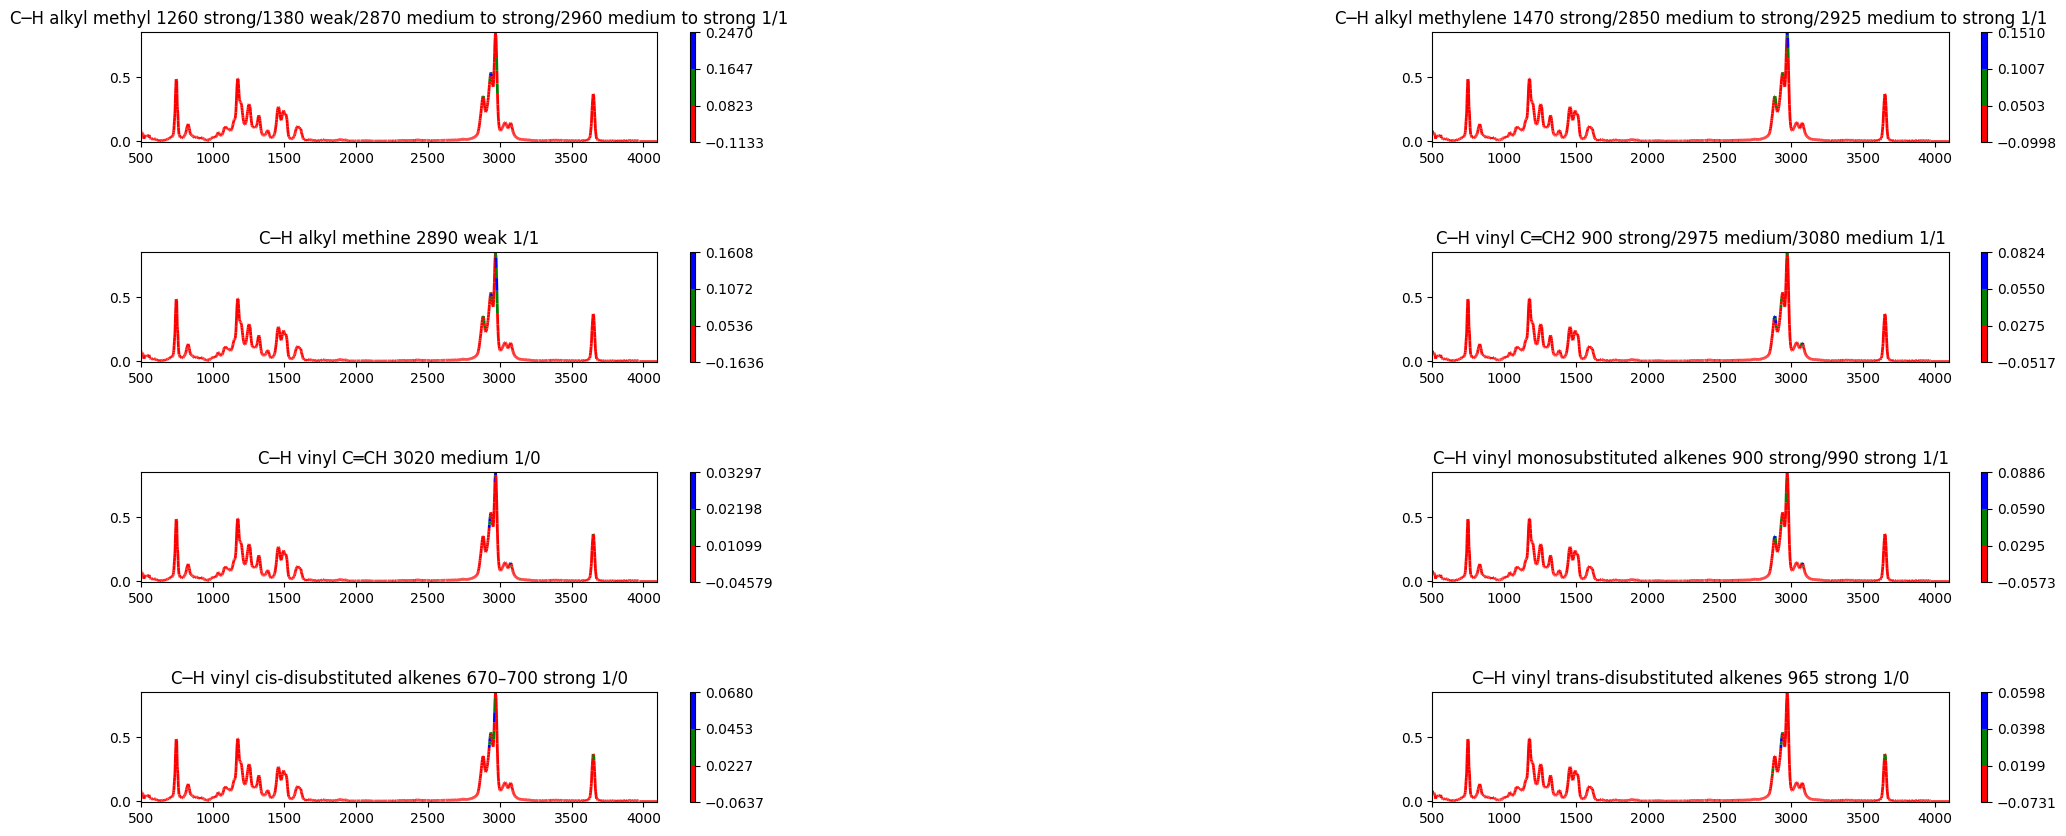

In [ ]:
view_all_classes_shap(shap_values, inx2cls, 2,  mode = 'segments')

# Реализация GradCAM

https://colab.research.google.com/drive/1M2f0pHswAKZ-bpp5xhzW8EEOB7J77qla?usp=sharing#scrollTo=Q9h4QmPSa599

In [ ]:
!pip install grad-cam
clear_output()

In [ ]:
batch = next(iter(dataloader_ir_test))
num = 5
test_specs, test_labels = batch
test_spec = test_specs[num]
test_label = test_labels[num]
test_spec = torch.unsqueeze(test_spec, dim=0)

In [ ]:
test_spec.size()

torch.Size([1, 3, 1800])

In [ ]:
class ForwardHook():

    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, input_, output): 
        self.activation = output.detach().clone()

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
      self.hook.remove()

In [ ]:
with ForwardHook(model._modules['layer7']) as forward_hook:
    output = model.eval()(test_spec)
    activation = forward_hook.activation

print(activation.shape)

torch.Size([1, 400, 56])


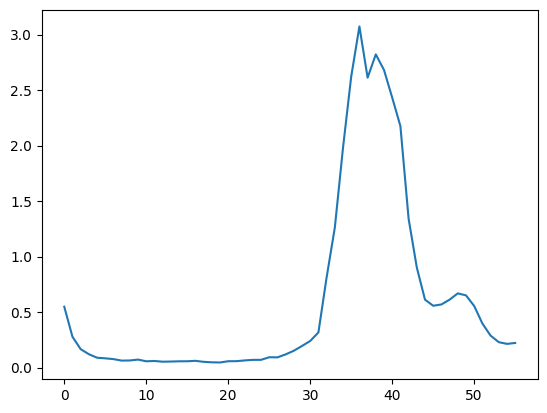

In [ ]:
plt.plot(activation[0].T.mean(axis = 1))

In [ ]:
import torch.nn.functional as F

number_of_top_classes = 6

prediction = F.softmax(output, dim=1)
top_props, top_inds = prediction.topk(number_of_top_classes)


for i in range(number_of_top_classes):
    category_name = inx2cls[top_inds[0][i].item()]
    score = top_props[0][i].item()
    print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

C─H aromatic benzene/sub. benzene 3070 weak 9: 79.4%
C═C aromatic C═C any 1450/1500/1580/1600 weak to strong (usually 3 or 4) 28: 20.0%
C─H alkyl methylene 1470 strong/2850 medium to strong/2925 medium to strong 1: 0.3%
C─H alkyl methyl 1260 strong/1380 weak/2870 medium to strong/2960 medium to strong 0: 0.1%
C─H aromatic monosubstituted benzene 700–750 strong 10: 0.0%
C─H aromatic monosubstituted benzene 690–710 strong 11: 0.0%


In [ ]:
class HookBackward():
    def __init__(self, layer):
        self.hook = layer.register_backward_hook(self.hook_func) 

    def hook_func(self, layer, grad_input_, grad_output): 
        self.grad = grad_output[0].detach().clone().mean(dim=[2], keepdim=True)

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
        self.hook.remove()

In [ ]:
with HookBackward(model._modules['layer7']) as backward_hook:
        with ForwardHook(model._modules['layer7']) as forward_hook:
            output = model.eval()(test_spec)
            activation = forward_hook.activation
        output[0, top_inds[0][i]].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
print(output)
print(activation[0][0])
print(weight[0][0])
print((weight[0] * activation[0]).sum(0))

print(cam_map)
print(test_label)

tensor([[  3.0310,   4.3731,  -3.0152,  -6.9458,  -5.1035,  -8.3281,  -7.2615,
          -8.2324,  -4.1495,   9.8111,   2.1456,   2.0788,  -1.6595,  -4.6214,
          -3.8677,  -2.1655,  -7.2547,  -6.3857,  -8.1767,  -8.6188,  -6.6992,
          -5.8357,  -4.9521,  -5.5148,  -7.9997,  -5.2285,  -5.5877,  -5.1146,
           8.4342,  -9.7125,  -8.7517,  -6.0101,  -8.6004,  -5.3407, -12.7978,
          -7.5276, -10.4214,  -4.5461,  -8.9679, -11.0661,  -8.1631,  -5.9581,
         -12.1448,  -5.7433,  -6.9325,  -3.9343,  -3.5169,  -9.5195,  -4.8265,
          -6.4310,  -5.8345,  -5.1048,  -5.8482,  -7.7374,  -7.0205,  -3.9993,
           0.8685,  -5.6323,  -4.5636, -12.4437,  -5.4677,  -7.1430,  -7.0580,
          -7.9643,  -5.1484,  -7.2889, -10.5084, -15.1458,  -4.4744,  -9.5147,
          -5.3499,  -7.0008]], grad_fn=<AddmmBackward0>)
tensor([ 2.4586,  0.0000,  0.5919,  0.2757,  0.5939,  0.7538,  0.0953,  0.0590,
         0.1192,  0.1725,  0.1104,  0.2035,  0.0865,  0.0000,  0.0000,  0

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [ ]:
def get_cam_map(model, layer, img, class_num):
    with HookBackward(layer) as backward_hook:
        with ForwardHook(layer) as forward_hook:
            output = model.eval()(img)
            activation = forward_hook.activation
        output[0, class_num].backward()
        weight = backward_hook.grad
        cam_map = F.relu((weight[0] * activation[0]).sum(0)).detach().cpu()
    return cam_map

In [ ]:
cam_map = get_cam_map(model, model._modules['layer7'], test_spec,  0)

In [ ]:
cam_map.shape

torch.Size([56])

In [ ]:
from scipy.interpolate import interp1d
def cam_map_interpolate(cam_map):
  cam_map_x = []
  for i in range(56):
    cam_map_x.append(i*3600/55+500)
  cam_map_x = torch.Tensor(cam_map_x)
  #print(len(cam_map_x))
  f = interp1d(cam_map_x, cam_map)
  cam_map_y = f(cam_map_x)
  return cam_map_y

In [ ]:
# plot the feature attributions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
def calc_cam_values(model, dataloader, layer, num_classess = 17, num_test_samples = 1):
  #Создаём тестовый объект
  batch = next(iter(dataloader))
  images, labels = batch
  if len(batch)>(100+num_test_samples):
     background = images[:100]
     test_images = images[100:(100+num_test_samples)]
     test_labels = labels[100:(100+num_test_samples)]
  else: 
    background = images[:(-num_test_samples-1)]
    test_images = images[(-num_test_samples-1):-1]
    test_labels = labels[(-num_test_samples-1):-1]
  model.eval()
  pred = model(test_images).detach().numpy()
  for i in range(len(pred)):
    pred[i][pred[i]>=0.5] = 1
    pred[i][pred[i]<0.5] = 0
  cam_map_all = []
  
  for image in test_images:
    cam_map_image = []
    #print(image.shape)
    image = image.unsqueeze(0)
    #print(image.shape)
    for i in range(num_classess):
      cam_map = get_cam_map(model, layer, image, i)
      cam_map_image.append(cam_map_interpolate(cam_map))
    cam_map_all.append(cam_map_image)
  cam_plus_img = {}
  cam_plus_img['image'] = test_images
  cam_plus_img['cam_map'] = cam_map_all
  cam_plus_img['labels'] = test_labels
  cam_plus_img['pred'] = pred
  clear_output()
  return cam_plus_img

In [ ]:
cam_plus_img = calc_cam_values(model, dataloader_ir_test, model._modules['layer7'], num_classess=72, num_test_samples = 3)

In [ ]:
len(cam_plus_img['cam_map'][0])

72

In [ ]:
def plot_cam_continuous(x, y, row_num, col_num, fig, axs, cam_map, title, ones):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= ones:
            dydx = cam_map
            # Create a continuous norm to map from data points to colors
            norm = plt.Normalize(dydx.min(), dydx.max())
            lc = LineCollection(segments, cmap='copper', norm=norm)
            # Set the values used for colormapping
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min()-0.00001, x.max()+0.000001)
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)
     
def plot_can_segments(x, y, row_num, col_num, fig, axs, cam_map, title, ones):
  points = np.array([x, y]).T.reshape(-1, 1, 2)
  segments = np.concatenate([points[:-1], points[1:]], axis=1)
  if row_num*col_num <= ones:
            dydx = cam_map

            # Use a boundary norm instead
            cmap = ListedColormap(['r', 'g', 'y', 'b'])
            norm = BoundaryNorm([dydx.min()-0.000001, dydx.max()/3+0.0000003, dydx.max()*2/3+0.0000006, dydx.max()+0.000001], cmap.N)
            lc = LineCollection(segments, cmap=cmap, norm=norm)
            lc.set_array(dydx)
            lc.set_linewidth(2)
            line = axs.add_collection(lc)
            #print(line)
            fig.colorbar(line, ax=axs)
            axs.set_xlim(x.min(), x.max())
            ly=y.max()
            axs.set_ylim(-0.01*ly, ly)
            axs.set_title(title)
            fig.set_figheight(20)
            fig.set_figwidth(30)

def view_all_classes_cam(cam_plus_img, inx2cls, num = 0,  mode = 'segments'):
  test_spectra = cam_plus_img['image'][num]
  cam_map_all = cam_plus_img['cam_map'][num]
  test_labels = cam_plus_img['labels'][num].detach().numpy()
  pred = cam_plus_img['pred'][num]
  x, y = test_spectra[:2]
  x, y = np.array(x), np.array(y)
  ones = len(test_labels[test_labels == 1])
  if ones%2 == 1: rows=(ones+1)//2
  else: rows = ones//2
  #only positive samples
  
  pred = pred[test_labels==1]
  cam_map_all1 = []
  for i in range(len(test_labels)):
    if test_labels[i]==1:
      cam_map_all1.append(cam_map_all[i])
  #print(cam_map_all1)
  test_labels = test_labels[test_labels==1]
  
  rows, cols = rows, 2
  fig, axs = plt.subplots(rows, cols, figsize=(5, 10))
  graph_nums = ones
  if mode == 'continuous':
    for i in range(graph_nums):
      if test_labels[i] == 0: continue
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      #print(title)
      plot_cam_continuous(x, y, row, col, fig, axs[row][col], cam_map_all[i], title, ones)
      
   
  elif mode == 'segments':
    
    for i in range(graph_nums):
      if test_labels[i] == 0: continue
      row = round(i//cols)
      col = i-row*cols
      label = list(np.array(test_labels, dtype = np.int32))[i]
      pred_title = list(np.array(pred, dtype = np.int32))[i]
      title = inx2cls[i]+' '+str(label)+'/'+str(pred_title)
      
      plot_can_segments(x, y, row, col, fig, axs[row][col], cam_map_all[i], title, ones)
      
  
  plt.show()


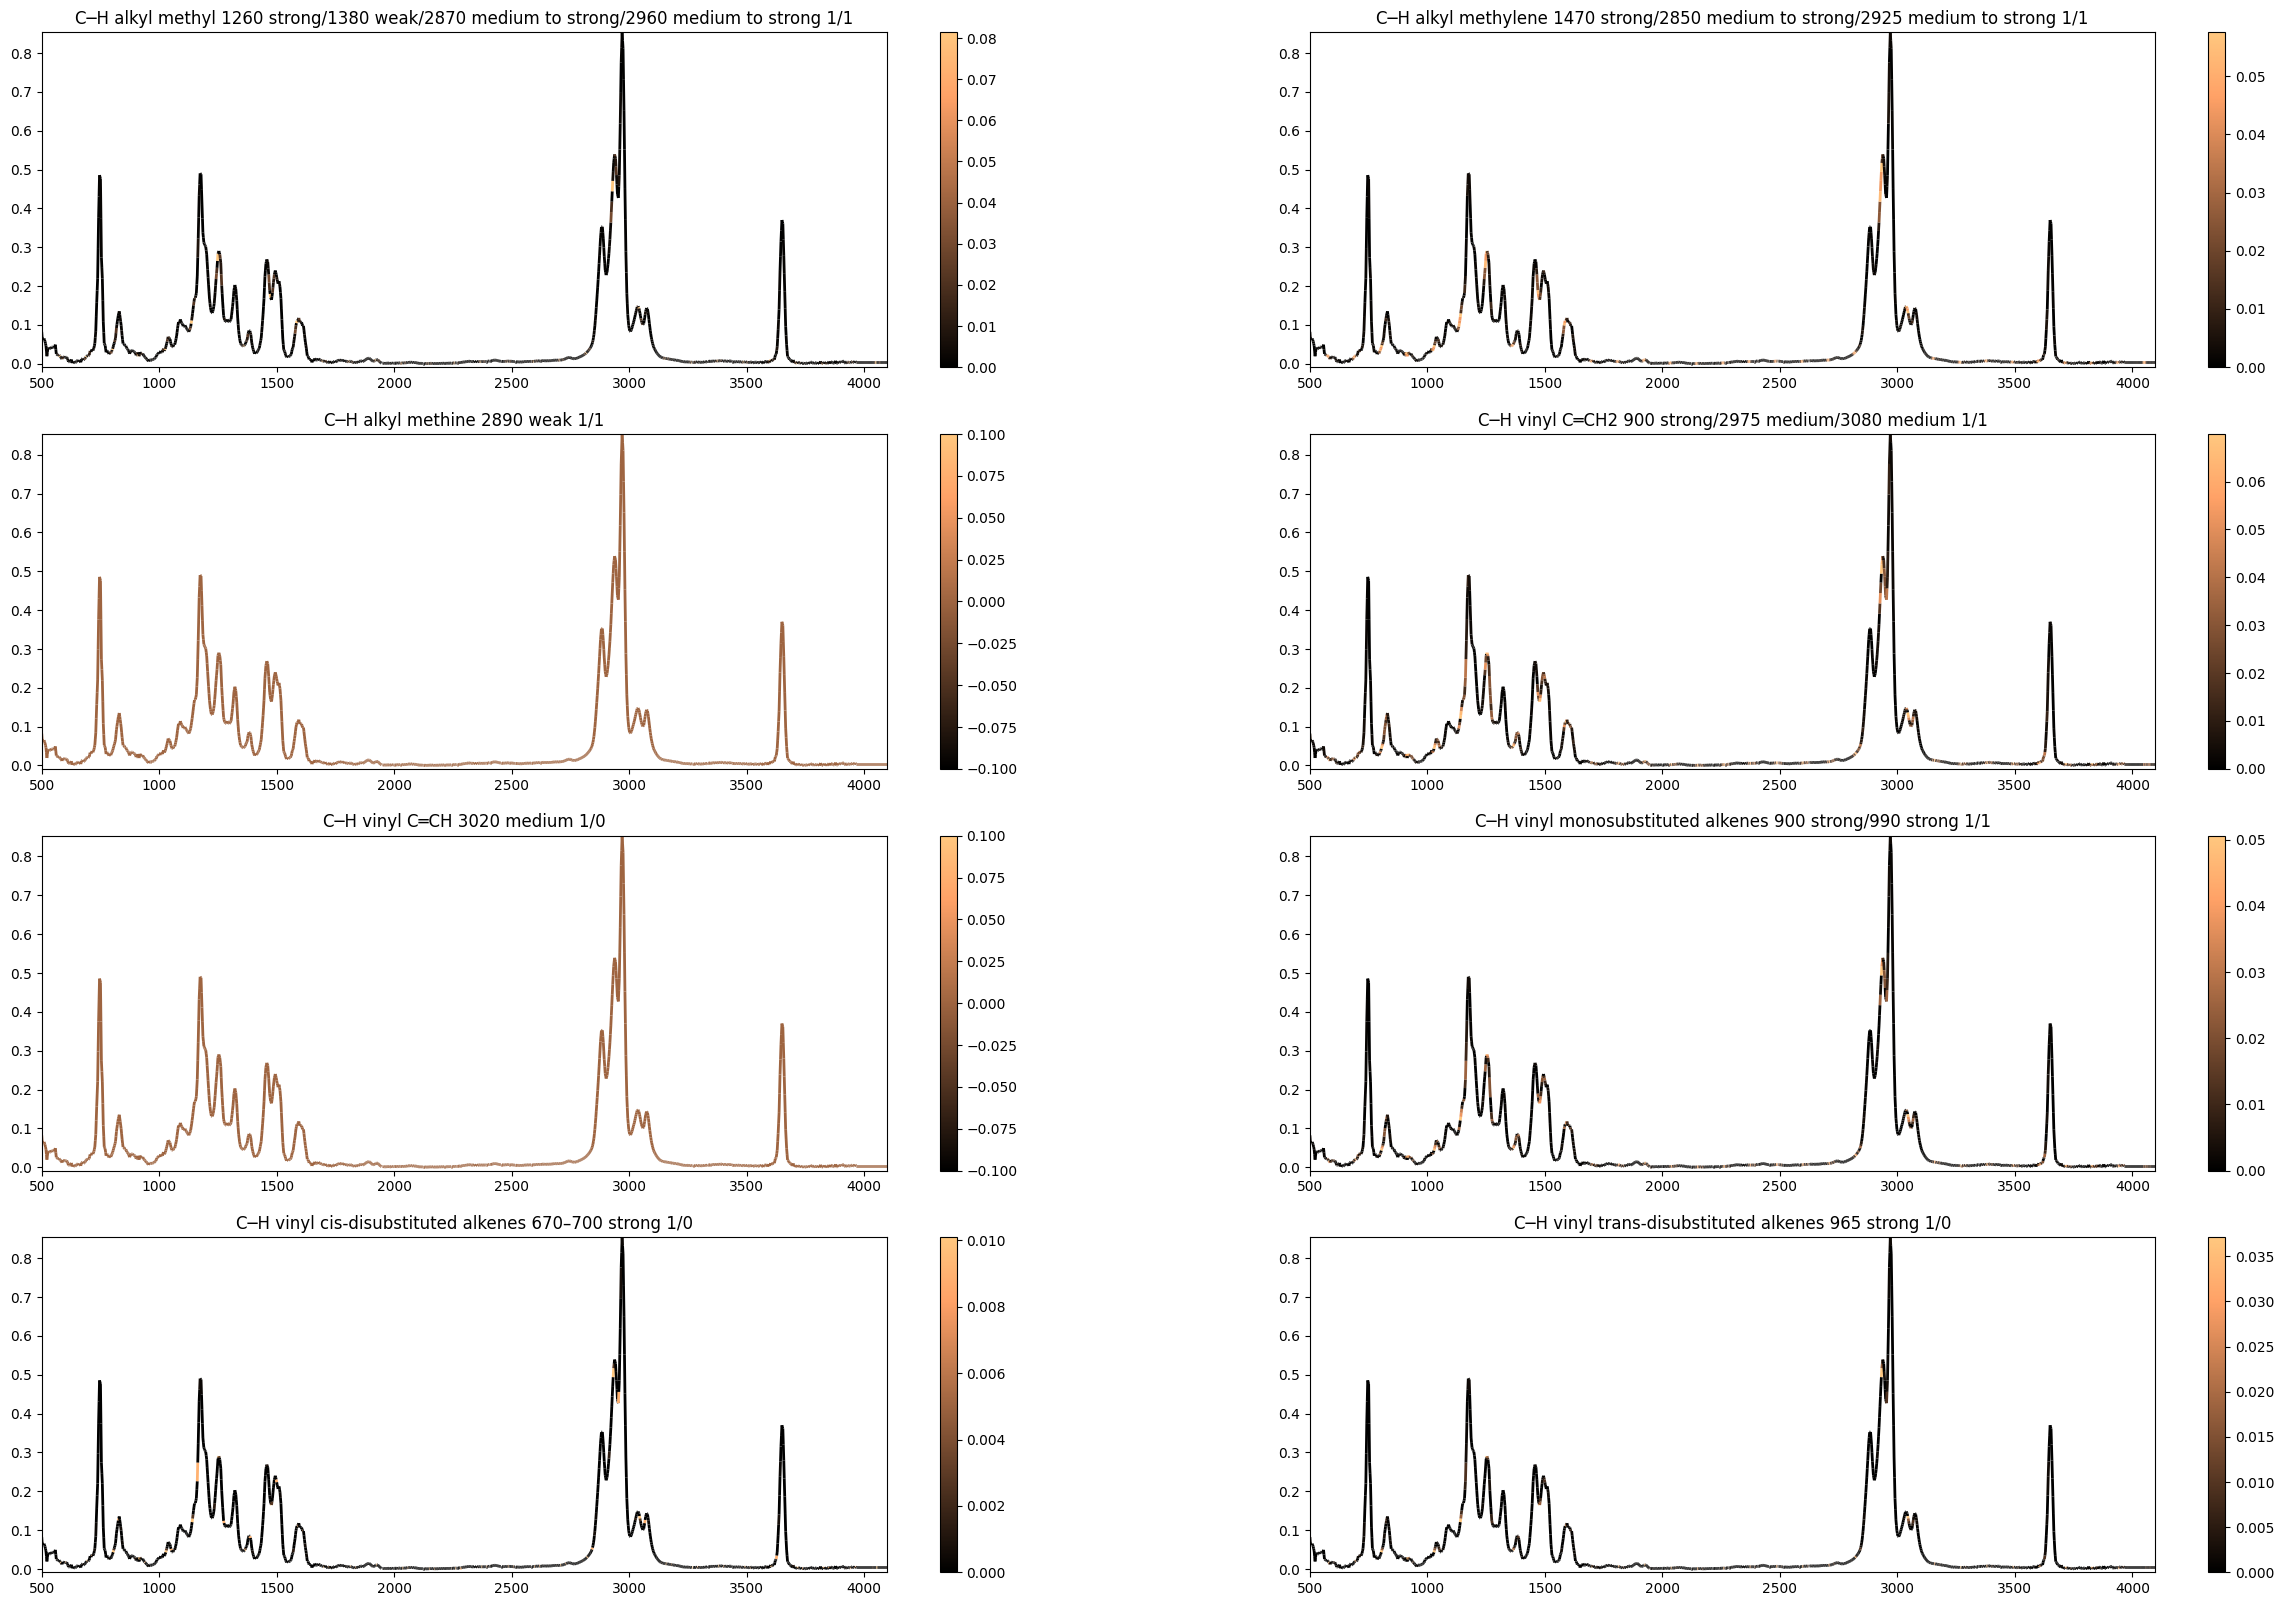

In [ ]:
view_all_classes_cam(cam_plus_img, inx2cls, num = 2,  mode = 'continuous')

# Конец

## Сохранение модели